In [153]:
import pandas as pd
goalkeeper_data_df = pd.read_csv('/kaggle/input/combined-data/goalkeeper_data.csv')
outfield_data_df = pd.read_csv('/kaggle/input/combined-data/outfield_data.csv')

# Splitting the dataset
First we split the dataset (outfield players and goalkeepers) into training and test data.
* Note the imbalance of dataset because it is expected that only a handful of players get injured during the course of the season.
* We want to transform categorical features such as 'League', 'Position' and 'Categorized Position' into numerical values to feed into the model using One Hot Encoding
* Target variables are 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate'; the things we would want to predict

In [154]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, cols):
    # Create a OneHotEncoder object
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit and transform the 'Position' column
    df_encoded = pd.DataFrame(encoder.fit_transform(df[cols]))
    df_encoded.columns = encoder.get_feature_names_out()

    df.drop(cols, axis=1, inplace=True)
    return pd.concat([df, df_encoded], axis = 1)

outfield_cols = ['Position', 'Categorized Position', 'League']
gk_cols = ['League']
outfield_data_df = one_hot_encoding(outfield_data_df, outfield_cols)
goalkeeper_data_df = one_hot_encoding(goalkeeper_data_df, gk_cols)

In [155]:
from sklearn.model_selection import train_test_split

# Select features (X) and target variable (y)
outfield_X = outfield_data_df.drop(['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
outfield_y = outfield_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]
goalkeeper_X = goalkeeper_data_df.drop(['Position', 'Categorized Position', 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
goalkeeper_y = goalkeeper_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]

# Split the data into training and testing sets
outfield_X_train, outfield_X_test, outfield_y_train, outfield_y_test = train_test_split(outfield_X, outfield_y, test_size=0.2, random_state=42)
goalkeeper_X_train, goalkeeper_X_test, goalkeeper_y_train, goalkeeper_y_test = train_test_split(goalkeeper_X, goalkeeper_y, test_size=0.2, random_state=42)

In [156]:
# Export datasets
outfield_X_train.to_csv('outfield_X_train.csv', index=False)
outfield_X_test.to_csv('outfield_X_test.csv', index=False)
outfield_y_train.to_csv('outfield_y_train.csv', index=False)
outfield_y_test.to_csv('outfield_y_test.csv', index=False)
goalkeeper_X_train.to_csv('goalkeeper_X_train.csv', index=False)
goalkeeper_X_test.to_csv('goalkeeper_X_test.csv', index=False)
goalkeeper_y_train.to_csv('goalkeeper_y_train.csv', index=False)
goalkeeper_y_test.to_csv('goalkeeper_y_test.csv', index=False)

# Analysis of training data
We want to identify the general behaviour of our training dataset. We can do so by reducing the dimensionality using Linear Discrimnant Analysis and Principle Component Analysis. This helps us:
* Reduce dimensions of our features
* Identify any linear seperability between targets

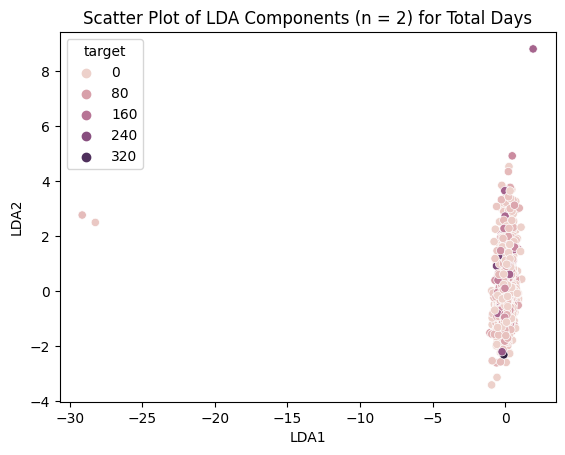

In [157]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Create LDA model
lda = LDA(n_components=2)  # Adjust n_components as needed

# Fit and transform the data
outfield_X_lda = lda.fit_transform(outfield_X_train, outfield_y_train['Total Days'])

# Create a new DataFrame with LDA components
lda_df = pd.DataFrame(outfield_X_lda, columns=['LDA1', 'LDA2'])

# Combine with target variable
lda_df['target'] = outfield_y_train['Total Days']

# Visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='LDA1', y='LDA2', hue='target', data=lda_df).set(title = 'Scatter Plot of LDA Components (n = 2) for Total Days')
plt.show()

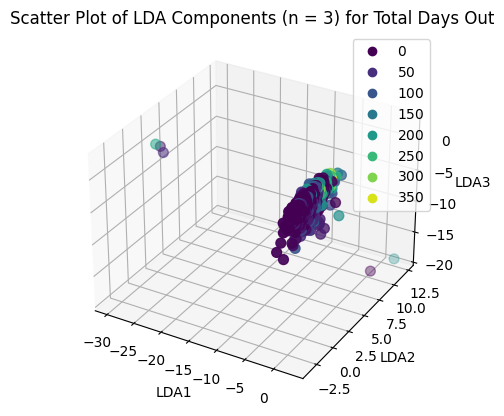

In [158]:
# Create LDA model
lda = LDA(n_components=3)  # Adjust n_components as needed

# Fit and transform the data
outfield_X_lda = lda.fit_transform(outfield_X_train, outfield_y_train['Total Days'])

# Create a new DataFrame with LDA components
lda_df = pd.DataFrame(outfield_X_lda, columns=['LDA1', 'LDA2', 'LDA3'])

# Combine with target variable
# lda_df['target'] = outfield_y_train['Total Days']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assuming you have a target variable named 'target'
scatter = ax.scatter(outfield_X_lda[:, 0], outfield_X_lda[:, 1], outfield_X_lda[:, 2], c=outfield_y_train['Total Days'], cmap='viridis', s=50)

ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')
ax.set_zlabel('LDA3')
ax.set_title('Scatter Plot of LDA Components (n = 3) for Total Days Out')

plt.legend(*scatter.legend_elements())
plt.show()

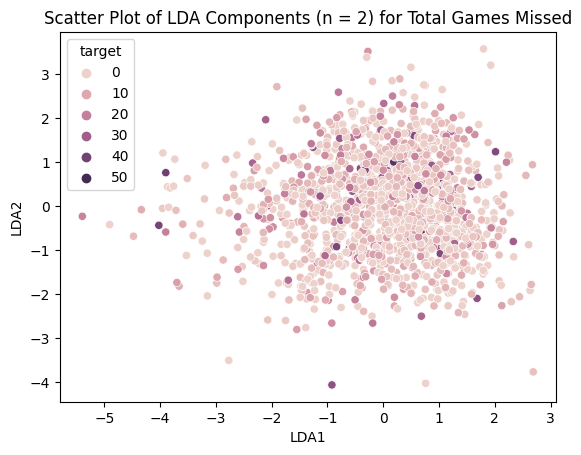

In [159]:
# Create LDA model
lda = LDA(n_components=2)  # Adjust n_components as needed

# Fit and transform the data
outfield_X_lda = lda.fit_transform(outfield_X_train, outfield_y_train['Total Games Missed'])

# Create a new DataFrame with LDA components
lda_df = pd.DataFrame(outfield_X_lda, columns=['LDA1', 'LDA2'])

# Combine with target variable
lda_df['target'] = outfield_y_train['Total Games Missed']

# Visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='LDA1', y='LDA2', hue='target', data=lda_df).set(title = 'Scatter Plot of LDA Components (n = 2) for Total Games Missed')
plt.show()

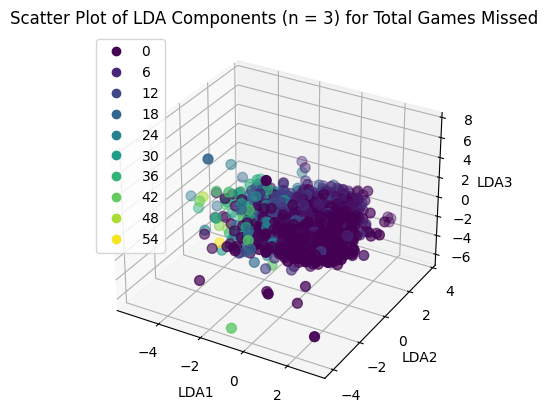

In [160]:
# Create LDA model
lda = LDA(n_components=3)  # Adjust n_components as needed

# Fit and transform the data
outfield_X_lda = lda.fit_transform(outfield_X_train, outfield_y_train['Total Games Missed'])

# Create a new DataFrame with LDA components
lda_df = pd.DataFrame(outfield_X_lda, columns=['LDA1', 'LDA2', 'LDA3'])

# Combine with target variable
# lda_df['target'] = outfield_y_train['Total Days']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assuming you have a target variable named 'target'
scatter = ax.scatter(outfield_X_lda[:, 0], outfield_X_lda[:, 1], outfield_X_lda[:, 2], c=outfield_y_train['Total Games Missed'], cmap='viridis', s=50)

ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')
ax.set_zlabel('LDA3')
ax.set_title('Scatter Plot of LDA Components (n = 3) for Total Games Missed')

plt.legend(*scatter.legend_elements())
plt.show()

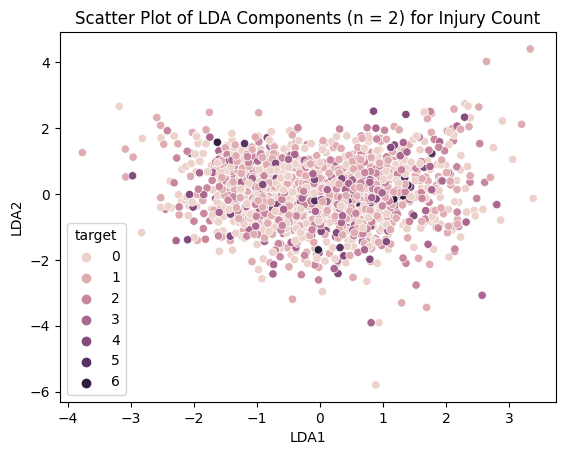

In [161]:
# Create LDA model
lda = LDA(n_components=2)  # Adjust n_components as needed

# Fit and transform the data
outfield_X_lda = lda.fit_transform(outfield_X_train, outfield_y_train['Injury Count'])

# Create a new DataFrame with LDA components
lda_df = pd.DataFrame(outfield_X_lda, columns=['LDA1', 'LDA2'])

# Combine with target variable
lda_df['target'] = outfield_y_train['Injury Count']

# Visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='LDA1', y='LDA2', hue='target', data=lda_df).set(title = 'Scatter Plot of LDA Components (n = 2) for Injury Count')
plt.show()

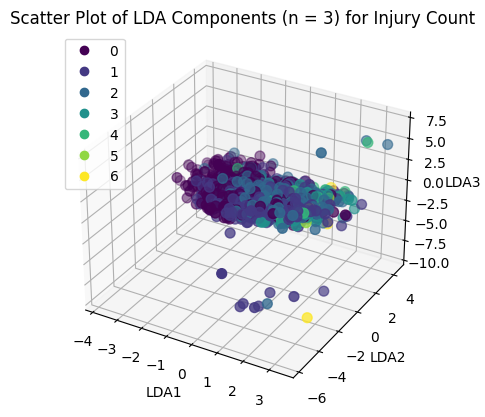

In [162]:
# Create LDA model
lda = LDA(n_components=3)  # Adjust n_components as needed

# Fit and transform the data
outfield_X_lda = lda.fit_transform(outfield_X_train, outfield_y_train['Injury Count'])

# Create a new DataFrame with LDA components
lda_df = pd.DataFrame(outfield_X_lda, columns=['LDA1', 'LDA2', 'LDA3'])

# Combine with target variable
# lda_df['target'] = outfield_y_train['Total Days']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assuming you have a target variable named 'target'
scatter = ax.scatter(outfield_X_lda[:, 0], outfield_X_lda[:, 1], outfield_X_lda[:, 2], c=outfield_y_train['Injury Count'], cmap='viridis', s=50)

ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')
ax.set_zlabel('LDA3')
ax.set_title('Scatter Plot of LDA Components (n = 3) for Injury Count')

plt.legend(*scatter.legend_elements())
plt.show()

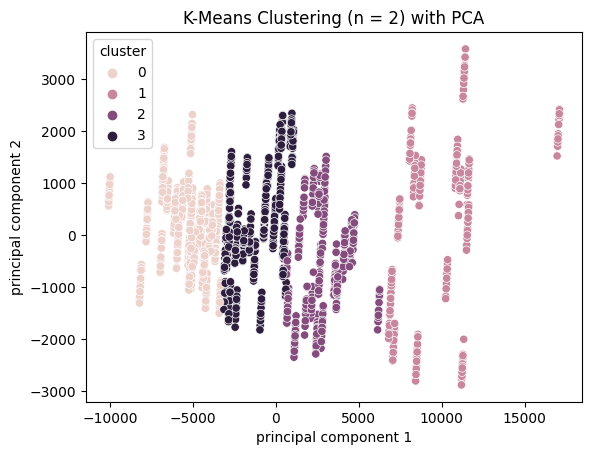

In [163]:
from sklearn.cluster import KMeans

# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(outfield_X_train)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Visualize the clusters using Seaborn
sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=principalDf)
plt.title('K-Means Clustering (n = 2) with PCA')
plt.show()

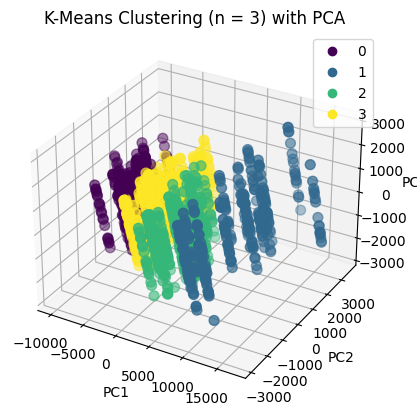

In [164]:
# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(outfield_X_train)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2', 'PCA3'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principalDf['PCA1'], principalDf['PCA2'], principalDf['PCA3'], c=principalDf['cluster'], cmap='viridis', s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.legend(*scatter.legend_elements())
plt.title('K-Means Clustering (n = 3) with PCA')
plt.show()

# Simple Linear Regression Model

In [170]:
targets = ['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']
def get_linear_regression_scores(target):
    model = LinearRegression()
    model.fit(outfield_X_train, outfield_y_train[target])

    # Make predictions on the test set
    outfield_y_pred = model.predict(outfield_X_test)

    # Calculate the MSE
    mse = mean_squared_error(outfield_y_test[target], outfield_y_pred)

    print("Mean Squared Error for ", target, ":", mse)

    # Calculate the R-squared score
    r2 = r2_score(outfield_y_test[target], outfield_y_pred)

    print("R-squared for ", target, ":", r2, "\n")

for target in targets:
    get_linear_regression_scores(target)

Mean Squared Error for  Total Days : 3027.7330408169278
R-squared for  Total Days : 0.21979617500341964 

Mean Squared Error for  Total Games Missed : 56.7572459606551
R-squared for  Total Games Missed : 0.25154902936959933 

Mean Squared Error for  Injury Count : 1.0750159729334368
R-squared for  Injury Count : 0.19618174135053934 

Mean Squared Error for  Average Injury Cost : 0.01852986211114607
R-squared for  Average Injury Cost : 0.13970961660369274 

Mean Squared Error for  Injury Rate : 3.996004457323303e-08
R-squared for  Injury Rate : 0.6718454171727665 

